# Testing Navier-Stokes with a moving body in package `Whirl`

In [1]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

### Solve flow past a stationary body

Set the flow parameters

In [3]:
Re = 200; # Reynolds number
U = 0.0; # Free stream velocity
U∞ = (U,0.0);

Set up points on the body

In [4]:
n = 51;
a = 0.5; b = 0.1;
body = Bodies.Plate(1.0,n)

Plate with 51 points and length 1.0 and thickness 0.0
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


Set the motion to oscillatory pitch-heave kinematics

In [5]:
struct Falling <: Kinematics
    "Gravity"
    g :: Float64
end

function (p::Falling)(t)
    α = 0.0
    α̇ = 0.0
    α̈ = 0.0

    c = im*Complex128(0.5*p.g*t^2)
    ċ = im*Complex128(p.g*t)
    c̈ = im*Complex128(p.g)
    return c, ċ, c̈, α, α̇, α̈
end

In [6]:
falling = Falling(-1.0)
motion = RigidBodyMotion(falling)

Rigid Body Motion:
  ċ = -0.0 + 0.0im
  c̈ = -0.0 - 1.0im
  α̇ = 0.0
  α̈ = 0.0
  Falling(-1.0)

In [21]:
motion(0.5*Δt)

(-0.0 - 1.25e-5im, -0.0 - 0.005im, -0.0 - 1.0im, 0.0, 0.0, 0.0)

Transform the body with a specified initial position and orientation.

In [7]:
cent = 1.0 + 1.0im
α = 0.0
T = RigidTransform(cent,α)
T(body) # transform the body to the current configuration

Plate with 51 points and length 1.0 and thickness 0.0
   Current position: (1.0,1.0)
   Current angle (rad): 0.0


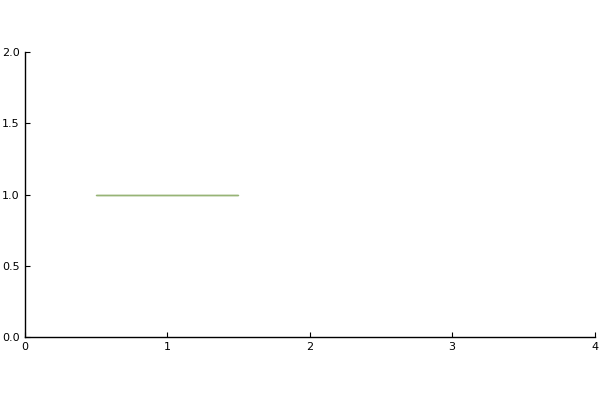

In [8]:
plot(body,xlim=(0,4),ylim=(0,2))

Now set up the coordinate data for operator construction

In [9]:
X = VectorData(body.x,body.y);
X̃ = VectorData(body.x̃,body.ỹ);

Set the domain size and time step size

In [10]:
nx = 202; ny = 102;
Ly = 2.0;
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re);
w₀ = Nodes(Dual,(nx,ny));
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:4.01, -0.01:0.02:2.0100000000000002)

### Now start constructing operators

#### Set up the state vector and constraint force vector for a moving body

In [11]:
u = (w₀,[real(cent),imag(cent),α])
f = (VectorData(X̃),Vector{Float64}());
sys = Systems.NavierStokes((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, isstore = true, isstatic = false)

Navier-Stokes system on a grid of size 202 x 102

In [12]:
ifherk = IFHERK(u,f,sys.Δt,
                ((t,u) -> Systems.plan_intfact(t,u,sys),
                 (t,u) -> eye(3)),
                (u,t) -> TimeMarching.plan_constraints(u,t,sys),
                ((u,t) -> Systems.r₁(u,t,sys,motion),
                 (u,t) -> Systems.r₂(u,t,sys,motion)),tol=1e-3,rk=TimeMarching.RK31,isstored=true,isstaticconstraints=false)

coord [0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0, 1.02, 1.04, 1.06, 1.08, 1.1, 1.12, 1.14, 1.16, 1.18, 1.2, 1.22, 1.24, 1.26, 1.28, 1.3, 1.32, 1.34, 1.36, 1.38, 1.4, 1.42, 1.44, 1.46, 1.48, 1.5][1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

coord [0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0, 1.02, 1.04, 1.06, 1.08, 1.1, 1.12, 1.14, 1.16, 1.18, 1.2, 1.22, 1.24, 1.26, 1.28, 1.3, 1.32, 1.34, 1.36, 1.38, 1.4, 1.42, 1.44, 1.46, 1.48, 1.5][1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

Order-3 IF-HERK integrator with
   State of type Tuple{Whirl.Fields.Nodes{Whirl.Fields.Dual,202,102},Array{Float64,1}}
   Force of type Tuple{Whirl.Fields.VectorData{51},Array{Float64,1}}
   Time step size 0.01


In [13]:
t = 0.0
w₀ .= 0.0
u = (w₀,[real(cent),imag(cent),α])
f = (VectorData(X̃),Vector{Float64}());
tf = Δt;
T = Δt:Δt:tf;
fx = Float64[];
fy = Float64[];
thist = [];
uhist = [];
tsample = 0.02;

In [14]:
@time for ti in T
    t, u, f = ifherk(t,u)
    
    # save data for later use
    push!(thist,t)
    push!(fx,sum(f[1].u)*Δx^2)
    push!(fy,sum(f[1].v)*Δx^2)
    push!(uhist,deepcopy(u))
end
println("solution completed through time t = ",t)

coord [0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0, 1.02, 1.04, 1.06, 1.08, 1.1, 1.12, 1.14, 1.16, 1.18, 1.2, 1.22, 1.24, 1.26, 1.28, 1.3, 1.32, 1.34, 1.36, 1.38, 1.4, 1.42, 1.44, 1.46, 1.48, 1.5][1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

motion [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

coord [0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0, 1.02, 1.04, 1.06, 1.0

In [15]:
f[1]

51 points of vector-valued data
  0.06274     59.5733
 -0.075757    45.7687
  0.0952952   62.9952
 -0.0789138   66.4122
  0.0883917   73.3216
 -0.0729796   78.0992
  0.0795778   82.7809
 -0.0661497   86.8551
  0.0708677   90.5732
 -0.0590774   93.9277
  0.0623099   96.9731
 -0.0518706   99.734 
  0.0538591  102.236 
  ⋮                  
  0.0518706   99.734 
 -0.0623099   96.9731
  0.0590774   93.9277
 -0.0708677   90.5732
  0.0661497   86.8551
 -0.0795778   82.7809
  0.0729796   78.0992
 -0.0883917   73.3216
  0.0789138   66.4122
 -0.0952952   62.9952
  0.075757    45.7687
 -0.06274     59.5733

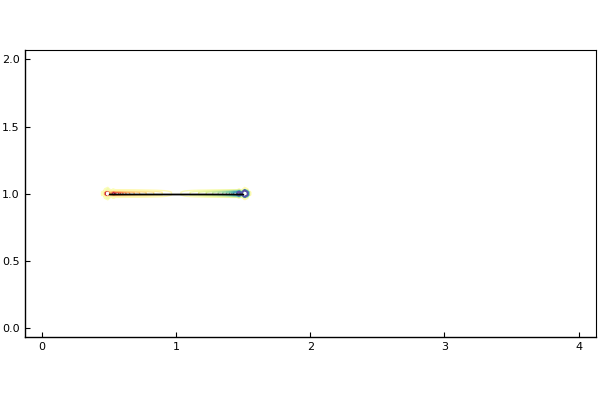

/home/julia/JuliaPro-0.6.2.2/JuliaPro/pkgs-0.6.2.2/v0.6/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'label'
  s)


In [16]:
plot(xg,yg,uhist[end][1],levels=linspace(-0.02,0.02,30))
Tr = RigidTransform(uhist[end][2])
Tr(body) # transform the body to the current configuration
plot!(body,linecolor=:black)

In [17]:
2*fx

1-element Array{Float64,1}:
 2.60014e-17

In [18]:
2*fy

1-element Array{Float64,1}:
 3.90972

In [19]:
motion(T[end])

(-0.0 - 5.0e-5im, -0.0 - 0.01im, -0.0 - 1.0im, 0.0, 0.0, 0.0)

In [20]:
u[2]

3-element Array{Float64,1}:
 1.0    
 0.99995
 0.0    